# Perceptron Multicamada no problema MNIST



### Disciplina: Noções de Inteligência Artificial - 2/2024
### Alunos: Felipe Lopes Gibin Duarte e Matheus das Neves Fernandes

## Introdução


Este trabalho implementa um Perceptron Multicamada (MLP) para resolver o problema de classificação de dígitos manuscritos do conjunto de dados MNIST. Foram exploradas diferentes arquiteturas e técnicas de treinamento, avaliando o desempenho de cada abordagem.


## 1. Preparação do Ambiente
Nesta seção, importamos as bibliotecas necessárias, carregamos o conjunto de dados MNIST e preparamos o dataloader


### 1.1. Importação de Bibliotecas

In [71]:
import tensorflow as tf
from d2l import tensorflow as d2l
d2l.use_svg_display()
import pdb
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

### 1.2. Carregamento e Pré-processamento dos Dados

In [10]:
class MNIST(d2l.DataModule):  # @save
    """O dataset MNIST."""
    
    def __init__(self, batch_size=64):
        super().__init__()
        self.save_hyperparameters()
        self.train, self.val = tf.keras.datasets.mnist.load_data()
        
    def get_dataloader(self, train):
        data = self.train if train else self.val
        process = lambda X, y: (tf.expand_dims(X, axis=3) / 255,tf.cast(y, dtype='int32'))
        resize_fn = lambda X, y: (tf.image.resize_with_pad(X,*self.resize), y)
        shuffle_buf = len(data[0]) if train else 1
        return tf.data.Dataset.from_tensor_slices(process(*data)).batch(self.batch_size).shuffle(shuffle_buf)

#Instancia o dataset
data = MNIST()

In [11]:
# Verifica o número de exemplos e formato dos dados
print(len(data.train[0]), len(data.val[0]))
print(data.train[0].shape)

60000 10000
(60000, 28, 28)


In [12]:
#Verifica um minibatch
X, y = next(iter(data.train_dataloader()))
print(X.shape, X.dtype, y.shape, y.dtype)

(64, 28, 28, 1) <dtype: 'float32'> (64,) <dtype: 'int32'>


## 2. Modelos e Arquiteturas
Nesta seção, implementamos diferentes arquiteturas e técnicas de treinamento para o MLP, avaliando o impacto no desempenho.


### 2a. Perceptron com uma Camada Escondida, Função Logística, Custo SSE e Descida de Gradiente


In [60]:
# Converte os rótulos para One-Hot
def preprocess_labels(dataset):
    return dataset.map(lambda X, y: (X, tf.one_hot(y, depth=10)))

# Prepara os dados para treinamento com os rotulos processados
train_dataloader = preprocess_labels(data.get_dataloader(train=True))
val_dataloader = preprocess_labels(data.get_dataloader(train=False))

In [62]:
model = tf.keras.Sequential([ 
    tf.keras.layers.Flatten(),  #Transforma a entrada (28x28) em vetor (784)
    tf.keras.layers.Dense(128, activation='sigmoid'),   #Camada escondida
    tf.keras.layers.Dense(10, activation='sigmoid')  #Camada de saída
])   

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate = 0.1),   #Descida por gradiente
    loss=tf.keras.losses.MeanSquaredError(),  #Erro quadrático médio
    metrics=['accuracy']
)

model.fit(
    train_dataloader,               # Dados de treinamento
    epochs=10,                       # Número de épocas
    validation_data=val_dataloader  # Dados de validação
)

# Salvar o modelo treinado
model_2a = model

#Identificação do modelo
model_name = "2a - função de ativação sigmoide, descida de gradiente"

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.2136 - loss: 0.0983 - val_accuracy: 0.3494 - val_loss: 0.0832
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4013 - loss: 0.0812 - val_accuracy: 0.5646 - val_loss: 0.0743
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5860 - loss: 0.0723 - val_accuracy: 0.6759 - val_loss: 0.0652
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6832 - loss: 0.0635 - val_accuracy: 0.7308 - val_loss: 0.0571
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7309 - loss: 0.0561 - val_accuracy: 0.7715 - val_loss: 0.0508
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7667 - loss: 0.0502 - val_accuracy: 0.7997 - val_loss: 0.0459
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7955 - loss: 0.0457 - val_accuracy: 0.8172 - val_loss: 0.0422
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8123 - loss: 0.0422 - val_accuracy: 0.

### 2b. Saída do tipo softmax, custo "entropia cruzada"

In [64]:
# Prepara os dados de treinamento sem conversão para One-Hot
train_dataloader = data.get_dataloader(train=True)
val_dataloader = data.get_dataloader(train=False)

In [65]:
model = tf.keras.Sequential([ 
    tf.keras.layers.Flatten(),  #Transforma a entrada (28x28) em vetor (784)
    tf.keras.layers.Dense(128, activation='sigmoid'),   #Camada escondida
    tf.keras.layers.Dense(10, activation='softmax')  #Camada de saída
])   

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate = 0.1),   #Descida por gradiente
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  #Entropia cruzada
    metrics=['accuracy']
)

model.fit(
    train_dataloader,               # Dados de treinamento
    epochs=10,                      # Número de épocas
    validation_data=val_dataloader  # Dados de validação
)

# Salvar o modelo treinado
model_2b = model

#Identificação do modelo
model_name = "2b - saida softmax, função de custo entropia cruzada"

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7328 - loss: 1.1083 - val_accuracy: 0.8942 - val_loss: 0.3824
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8966 - loss: 0.3705 - val_accuracy: 0.9115 - val_loss: 0.3121
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9091 - loss: 0.3200 - val_accuracy: 0.9191 - val_loss: 0.2803
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9193 - loss: 0.2831 - val_accuracy: 0.9260 - val_loss: 0.2606
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9248 - loss: 0.2650 - val_accuracy: 0.9285 - val_loss: 0.2495
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9276 - loss: 0.2530 - val_accuracy: 0.9339 - val_loss: 0.2321
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9314 - loss: 0.2378 - val_accuracy: 0.9373 - val_loss: 0.2190
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9396 - loss: 0.2138 - val_accuracy: 0.

### 2c. Otimizador Adam

In [66]:
model = tf.keras.Sequential([ 
    tf.keras.layers.Flatten(),  #Transforma a entrada (28x28) em vetor (784)
    tf.keras.layers.Dense(128, activation='sigmoid'),   #Camada escondida
    tf.keras.layers.Dense(10, activation='softmax')  #Camada de saída
])   

model.compile(
    optimizer=tf.keras.optimizers.Adam(),   #Otimizador Adam
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  #Entropia cruzada
    metrics=['accuracy']
)

model.fit(
    train_dataloader,               # Dados de treinamento
    epochs=10,                      # Número de épocas
    validation_data=val_dataloader  # Dados de validação
)

# Salvar o modelo treinado
model_2c = model

#Identificação do modelo
model_name = "2c - função de ativação sigmoide, otimizador Adam"

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8111 - loss: 0.7882 - val_accuracy: 0.9232 - val_loss: 0.2637
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9308 - loss: 0.2417 - val_accuracy: 0.9434 - val_loss: 0.1979
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9438 - loss: 0.1920 - val_accuracy: 0.9524 - val_loss: 0.1615
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9558 - loss: 0.1555 - val_accuracy: 0.9577 - val_loss: 0.1431
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9647 - loss: 0.1236 - val_accuracy: 0.9650 - val_loss: 0.1210
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9694 - loss: 0.1051 - val_accuracy: 0.9684 - val_loss: 0.1065
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9748 - loss: 0.0903 - val_accuracy: 0.9701 - val_loss: 0.1010
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9789 - loss: 0.0773 - val_accuracy: 0.

### 2d. A função Relu

In [55]:
model = tf.keras.Sequential([ 
    tf.keras.layers.Flatten(),  #Transforma a entrada (28x28) em vetor (784)
    tf.keras.layers.Dense(128, activation='relu'),   #Camada escondida
    tf.keras.layers.Dense(10, activation='softmax')  #Camada de saída
])   

model.compile(
    optimizer=tf.keras.optimizers.Adam(),   #Otimizador Adam
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  #Entropia cruzada
    metrics=['accuracy']
)

model.fit(
    train_dataloader,               # Dados de treinamento
    epochs=10,                      # Número de épocas
    validation_data=val_dataloader  # Dados de validação
)

# Salvar o modelo treinado
model_2d = model

#Identificação do modelo
model_name = "2d - função de ativação relu, otimizador Adam"

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8559 - loss: 0.5197 - val_accuracy: 0.9521 - val_loss: 0.1686
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9563 - loss: 0.1495 - val_accuracy: 0.9641 - val_loss: 0.1187
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9713 - loss: 0.1029 - val_accuracy: 0.9686 - val_loss: 0.0999
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9775 - loss: 0.0761 - val_accuracy: 0.9748 - val_loss: 0.0798
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9836 - loss: 0.0568 - val_accuracy: 0.9765 - val_loss: 0.0804
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9857 - loss: 0.0484 - val_accuracy: 0.9757 - val_loss: 0.0770
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9892 - loss: 0.0385 - val_accuracy: 0.9797 - val_loss: 0.0687
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9913 - loss: 0.0307 - val_accuracy: 0.

### 2e. Redes maiores

#### Camada escondida com 256 neurônios

In [54]:
model = tf.keras.Sequential([ 
    tf.keras.layers.Flatten(),  #Transforma a entrada (28x28) em vetor (784)
    tf.keras.layers.Dense(256, activation='relu'),   #Camada escondida
    tf.keras.layers.Dense(10, activation='softmax')  #Camada de saída
])   

model.compile(
    optimizer=tf.keras.optimizers.Adam(),   #Otimizador Adam
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  #Entropia cruzada
    metrics=['accuracy']
)

model.fit(
    train_dataloader,               # Dados de treinamento
    epochs=10,                      # Número de épocas
    validation_data=val_dataloader  # Dados de validação
)

# Salvar o modelo treinado
model_2e1 = model

#Identificação do modelo
model_name = "2e.1 - 1 camada escondida de 256 neurônios"

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.8718 - loss: 0.4532 - val_accuracy: 0.9583 - val_loss: 0.1349
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9652 - loss: 0.1176 - val_accuracy: 0.9703 - val_loss: 0.0930
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9794 - loss: 0.0742 - val_accuracy: 0.9751 - val_loss: 0.0773
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9855 - loss: 0.0495 - val_accuracy: 0.9754 - val_loss: 0.0754
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9885 - loss: 0.0389 - val_accuracy: 0.9775 - val_loss: 0.0729
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9909 - loss: 0.0294 - val_accuracy: 0.9796 - val_loss: 0.0688
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9936 - loss: 0.0224 - val_accuracy: 0.9805 - val_loss: 0.0691
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9945 - loss: 0.0191 - val_accuracy: 0.

#### 2 camadas escondidas com 256 neurônios cada

In [67]:
model = tf.keras.Sequential([ 
    tf.keras.layers.Flatten(),  #Transforma a entrada (28x28) em vetor (784)
    tf.keras.layers.Dense(256, activation='relu'),   #Camada escondida 1
    tf.keras.layers.Dense(256, activation='relu'),   #Camada escondida 2
    tf.keras.layers.Dense(10, activation='softmax')  #Camada de saída
])   

model.compile(
    optimizer=tf.keras.optimizers.Adam(),   #Otimizador Adam
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  #Entropia cruzada
    metrics=['accuracy']
)

model.fit(
    train_dataloader,               # Dados de treinamento
    epochs=10,                      # Número de épocas
    validation_data=val_dataloader  # Dados de validação
)

# Salvar o modelo treinado
model_2e2 = model

#Identificação do modelo
model_name = "2e.2 - 2 camadas escondidas de 256 neurônios"

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.8836 - loss: 0.4035 - val_accuracy: 0.9593 - val_loss: 0.1312
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9732 - loss: 0.0866 - val_accuracy: 0.9727 - val_loss: 0.0816
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9807 - loss: 0.0603 - val_accuracy: 0.9754 - val_loss: 0.0785
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9865 - loss: 0.0422 - val_accuracy: 0.9794 - val_loss: 0.0634
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9908 - loss: 0.0291 - val_accuracy: 0.9809 - val_loss: 0.0678
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9918 - loss: 0.0261 - val_accuracy: 0.9801 - val_loss: 0.0703
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9931 - loss: 0.0209 - val_accuracy: 0.9790 - val_loss: 0.0713
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9946 - loss: 0.0165 - val_accuracy: 0.

## 3. Visualização 
Nesta seção, vamos observar alguns exemplos mal classificados

In [29]:
# Predição no conjunto de validação e identificação de erros
def get_errors(data_loader, model):
    erros = []  # Lista para armazenar os exemplos mal classificados
    for X, y in data_loader:  # Iterar sobre o dataloader de validação
        preds = tf.argmax(model(X), axis=1)  # Previsões (classe com maior probabilidade)
        y = tf.cast(y, dtype=tf.int64)  # Converte rótulos para int64
        erros_batch = tf.where(preds != y)  # Identifica índices dos erros
        for idx in erros_batch.numpy():
            idx = idx.item()  # Extrai o valor escalar do tensor
            erros.append((X[idx].numpy(), y[idx].numpy(), preds[idx].numpy()))  # Armazena a imagem, rótulo real e predição errada
    return erros

In [57]:
def visualize_errors(erros, num_samples):
    plt.figure(figsize=(10, 10))
    for i in range(min(num_samples, len(erros))):
        img, true_label, pred_label = erros[i]
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img.squeeze(), cmap='gray')  # Exibe a imagem
        plt.title(f"Real: {true_label}\nPred: {pred_label}")
        plt.axis('off')
    plt.show()

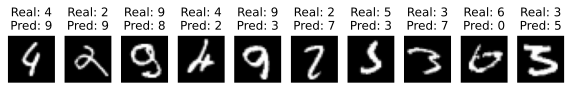

Número total de erros: 193
Modelo avaliado: 2e.1 - 1 camada escondida de 256 neurônios


In [69]:
# Obter erros no conjunto de validação do modelo especificado (neste caso o 2e1)
erros = get_errors(val_dataloader, model_2e1)

# Associar erros ao nome do modelo
erros_modelo = {"nome": model_name, "erros": erros}

# Visualizar erros (nesse caso do modelo 2e.1)
model_name = "2e.1 - 1 camada escondida de 256 neurônios"
visualize_errors(erros_modelo["erros"], num_samples=10)

print(f"Número total de erros: {len(erros)}")
print(f"Modelo avaliado: {model_name}")

## 4. Matriz de confusão
Vamos observar a matriz de confusão do melhor modelo (2e.1)